In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the paths
dataset_dir = r"D:\portfolio_of_data_science\brain_tumor_cnn\brain-tumor-mri-dataset"
output_dir = "D:\portfolio_of_data_science\Brain_tumor_cnn"

# Create output directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get classes (subfolders)
classes = os.listdir(dataset_dir)

# Split and copy files
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create class subfolders in train and test directories
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Move the files
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, cls, img))
    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, cls, img))

print("Dataset split into training and testing sets.")


Dataset split into training and testing sets.


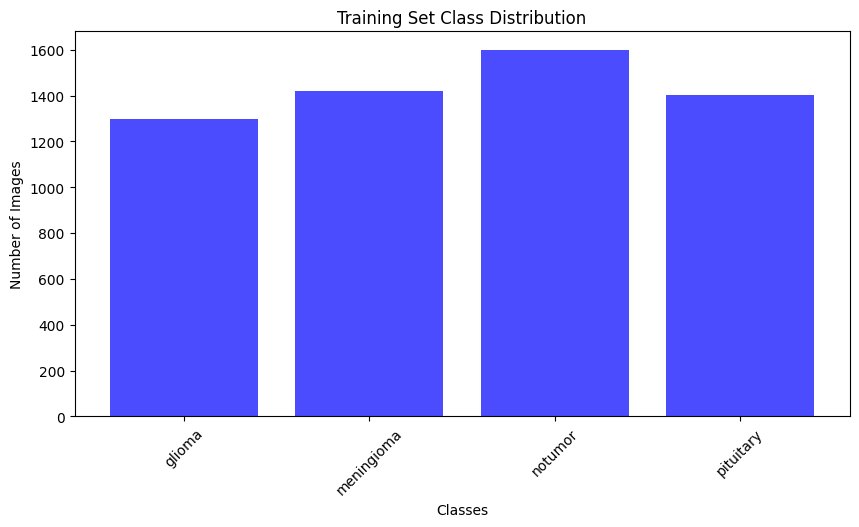

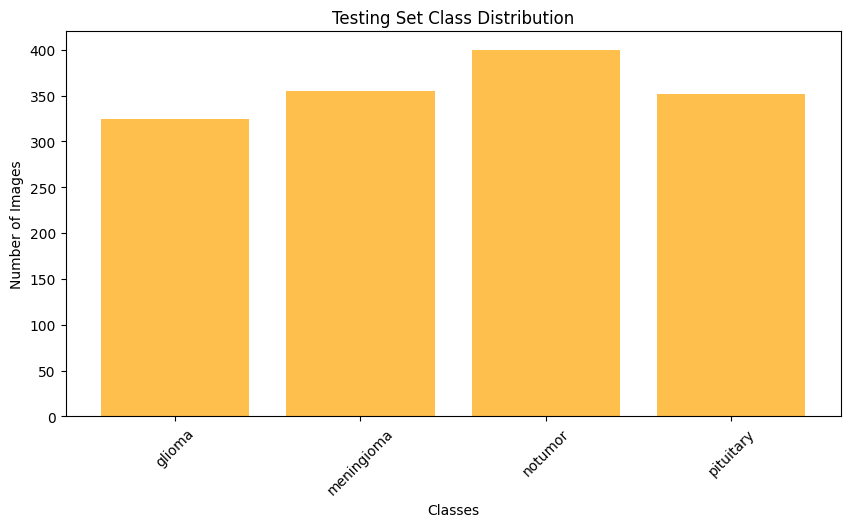

In [3]:
import matplotlib.pyplot as plt

# Count images in each class for train and test sets
train_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
test_class_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

# Plot training set distribution
plt.figure(figsize=(10, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue', alpha=0.7)
plt.title("Training Set Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

# Plot testing set distribution
plt.figure(figsize=(10, 5))
plt.bar(test_class_counts.keys(), test_class_counts.values(), color='orange', alpha=0.7)
plt.title("Testing Set Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


## Function To Show Random Images

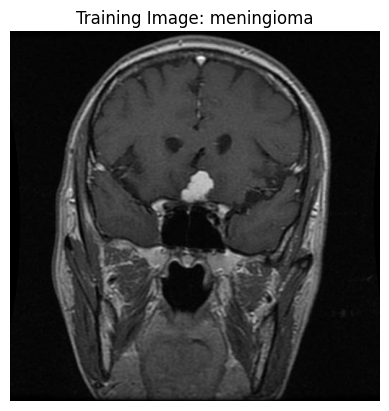

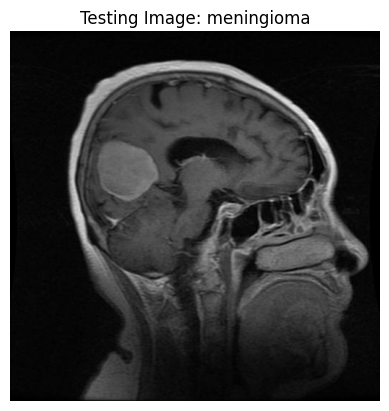

In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to show a random image from a directory
def show_random_image(data_dir, title):
    class_name = random.choice(os.listdir(data_dir))  # Randomly select a class
    class_dir = os.path.join(data_dir, class_name)
    image_name = random.choice(os.listdir(class_dir))  # Randomly select an image
    image_path = os.path.join(class_dir, image_name)

    # Display the image
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}: {class_name}")
    plt.axis("off")
    plt.show()

# Show one random image from training set
show_random_image(train_dir, "Training Image")

# Show one random image from testing set
show_random_image(test_dir, "Testing Image")


In [4]:
from PIL import Image
import random

# Function to get the shape (size) of a random image
def get_random_image_shape(data_dir):
    class_name = random.choice(os.listdir(data_dir))  # Randomly select a class
    class_dir = os.path.join(data_dir, class_name)
    image_name = random.choice(os.listdir(class_dir))  # Randomly select an image
    image_path = os.path.join(class_dir, image_name)

    # Load the image
    with Image.open(image_path) as img:
        shape = img.size  # Returns (width, height)
    return image_name, class_name, shape

# Get shape for a random training image
train_image, train_class, train_shape = get_random_image_shape(train_dir)
print(f"Training Image: {train_image} | Class: {train_class} | Shape: {train_shape}")

# Get shape for a random testing image
test_image, test_class, test_shape = get_random_image_shape(test_dir)
print(f"Testing Image: {test_image} | Class: {test_class} | Shape: {test_shape}")


Training Image: pi-0268.jpg | Class: pituitary | Shape: (512, 512)
Testing Image: pi-0757.jpg | Class: pituitary | Shape: (512, 512)


# Changing the size of the all the images into 512x512(Pixel)

In [5]:
from PIL import Image
import os

# Function to resize images and handle non-image files
def resize_images(data_dir, target_size=(512, 512)):
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            try:
                # Open the image
                with Image.open(image_path) as img:
                    # Convert to RGB if necessary
                    if img.mode != "RGB":
                        img = img.convert("RGB")
                    # Resize the image
                    img_resized = img.resize(target_size)
                    # Save the resized image (overwrite original)
                    img_resized.save(image_path)
            except (IOError, SyntaxError, OSError) as e:
                print(f"Skipping file {image_path}: {e}")

# Resize images in training and testing directories
resize_images(train_dir)
resize_images(test_dir)

print("All valid images have been resized to 512x512 and converted to RGB.")


All valid images have been resized to 512x512 and converted to RGB.


# **Lets Make A MODEL**

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [7]:
# Define paths to training and testing directories
train_dir = r"D:\portfolio_of_data_science\brain_tumor_cnn\train"
test_dir = r"D:\portfolio_of_data_science\brain_tumor_cnn\test"

In [8]:
# Image data generators for data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [9]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

Found 5721 images belonging to 4 classes.


In [11]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

Found 1432 images belonging to 4 classes.


In [12]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])

d:\anaconda\envs\MLDL\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

d:\anaconda\envs\MLDL\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1962s 10s/step - accuracy: 0.3913 - loss: 1.9969 - val_accuracy: 0.6585 - val_loss: 0.8384
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2005s 11s/step - accuracy: 0.5958 - loss: 0.9399 - val_accuracy: 0.7200 - val_loss: 0.7480
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1994s 11s/step - accuracy: 0.6510 - loss: 0.8695 - val_accuracy: 0.7123 - val_loss: 0.7046
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1753s 10s/step - accuracy: 0.6687 - loss: 0.8243 - val_accuracy: 0.7374 - val_loss: 0.6943
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1986s 11s/step - accuracy: 0.6786 - loss: 0.7981 - val_accuracy: 0.7870 - val_loss: 0.5747
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1808s 10s/step - accuracy: 0.7094 - loss: 0.7190 - val_accuracy: 0.7605 - val_loss: 0.6219
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1986s 11s/step - accuracy: 0.7151 - loss: 0.7312 - val_accuracy: 0.7793 - val_loss: 0.5648
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2190s 12s/step - accuracy: 0.7423 - loss: 0

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8131 - loss: 0.4814
Test Accuracy: 80.17%


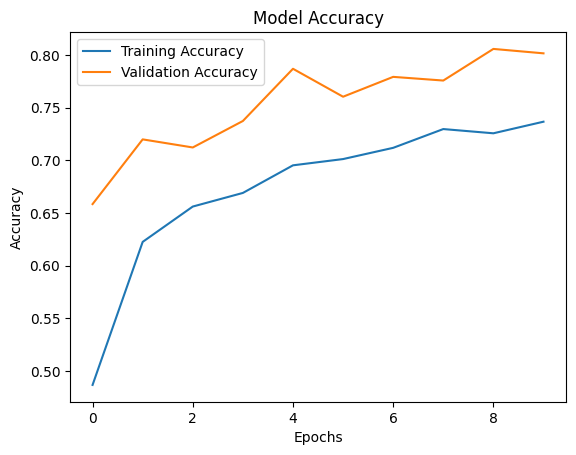

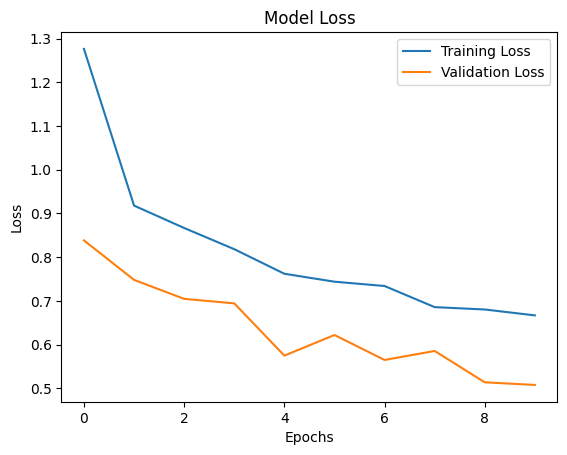

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
# === EXPORT THE TRAINED MODEL ===

# Create a directory to save models
export_dir = "saved_model"
os.makedirs(export_dir, exist_ok=True)

# 1. Save in Keras .h5 format
model.save(os.path.join(export_dir, "brain_tumor_model.h5"))
print("[INFO] Model saved in H5 format.")

[INFO] Model saved in H5 format.
